In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

idx = pd.IndexSlice

In [5]:
results = pd.read_csv(
    Path.cwd().parent /
    'summaries' /
    'total_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True
    )

results = results.loc[~(results.index.get_level_values(1) == 'balancing_volume')]

C:\Users\lukas\AppData\Local\Temp\ipykernel_5008\751304993.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results = pd.read_csv(


In [6]:

df = pd.read_excel(
    Path.cwd() / 'fuel_prices' / 'systemaveragepriceofgasdataset090125.xlsx',
    sheet_name=3,
    parse_dates=True,
    index_col=0,
    skiprows=1
    )

def process(df):

    df = (
        df.iloc[4:]
        .rename(
        columns={
            'Unnamed: 1': 'day_price',
            'Unnamed: 2': 'before_week_average',
        })
        .replace('[x]', np.nan)
        ['day_price']
        )
    df.index.name = 'date'

    return df

df = process(df)

df_2022 = df.loc['2022-01-01':'2023-01-01']
df_2023 = df.loc['2023-01-01':'2024-01-01']
df_2024 = df.loc['2024-01-01':'2025-01-01']

C:\Users\lukas\AppData\Local\Temp\ipykernel_5008\3667178241.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel(
C:\Users\lukas\AppData\Local\Temp\ipykernel_5008\3667178241.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('[x]', np.nan)


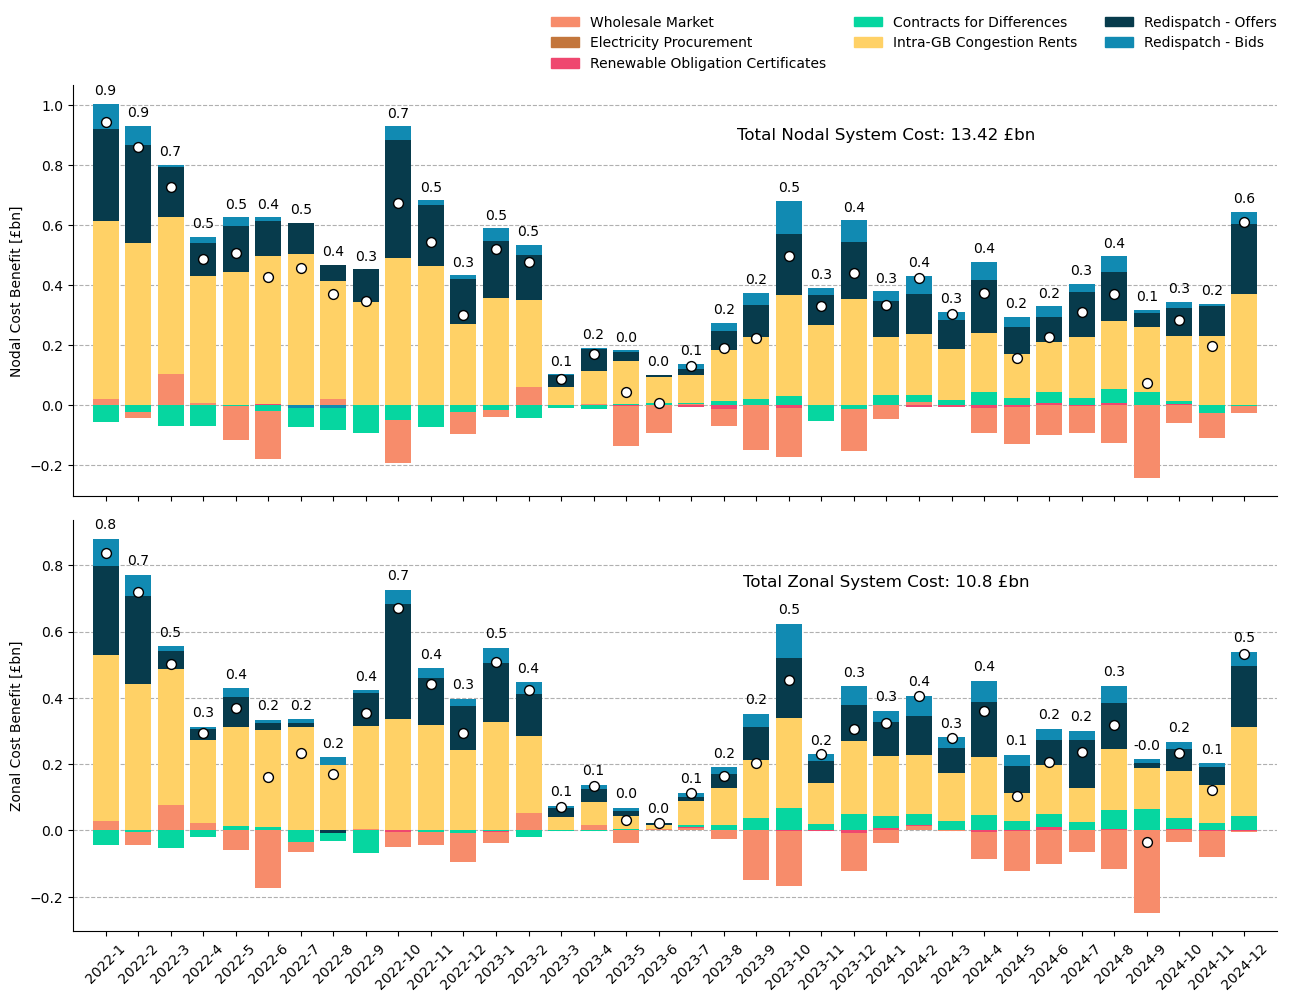

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(13, 10), sharex=True)


results

for layout, ax in zip(['nodal', 'zonal'], axs):

    ss = (results['national'] - results[layout]).unstack()

    ss = (
        ss
        .groupby([ss.index.year, ss.index.month]).sum().mul(1e-3)
    )
    for m in ss.index:
        stack_to_ax(ss.loc[[m]], ax, text_y_offset=0.03)

    ax.set_ylabel(f'{layout.capitalize()} Cost Benefit [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(ss))

    total_cost = ss.sum().sum()

    if layout == 'zonal':
        y = 0.75
    else:
        y = 0.9

    ax.text(
        len(ss) - 12, y,
        f'Total {layout.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[1].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    bbox_to_anchor=(1.01, 1.2),
    frameon=False,
    ncol=3
    )

plt.tight_layout()

plt.savefig('lmp_benefits.pdf', bbox_inches='tight')
plt.show()

In [14]:
total_fuel_price = pd.concat([df_2022, df_2023, df_2024])
total_fuel_price.index = pd.to_datetime(total_fuel_price.index)
total_fuel_price.index = total_fuel_price.index.strftime('%Y-%m-%d')

total_fuel_price

date
2022-01-01    1.5220
2022-01-02    2.0810
2022-01-03    5.3380
2022-01-04    6.3140
2022-01-05    7.6360
               ...  
2024-12-27    4.0761
2024-12-28    4.1741
2024-12-29    4.1607
2024-12-30    4.1013
2024-12-31    4.1601
Name: day_price, Length: 1096, dtype: float64

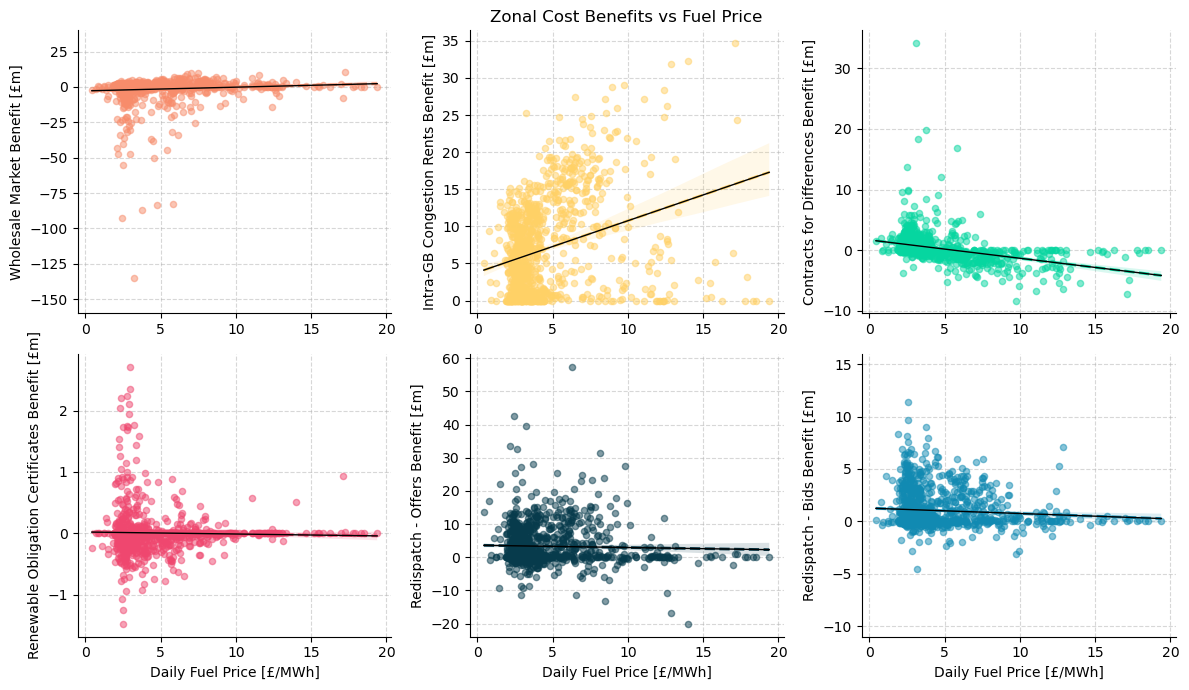

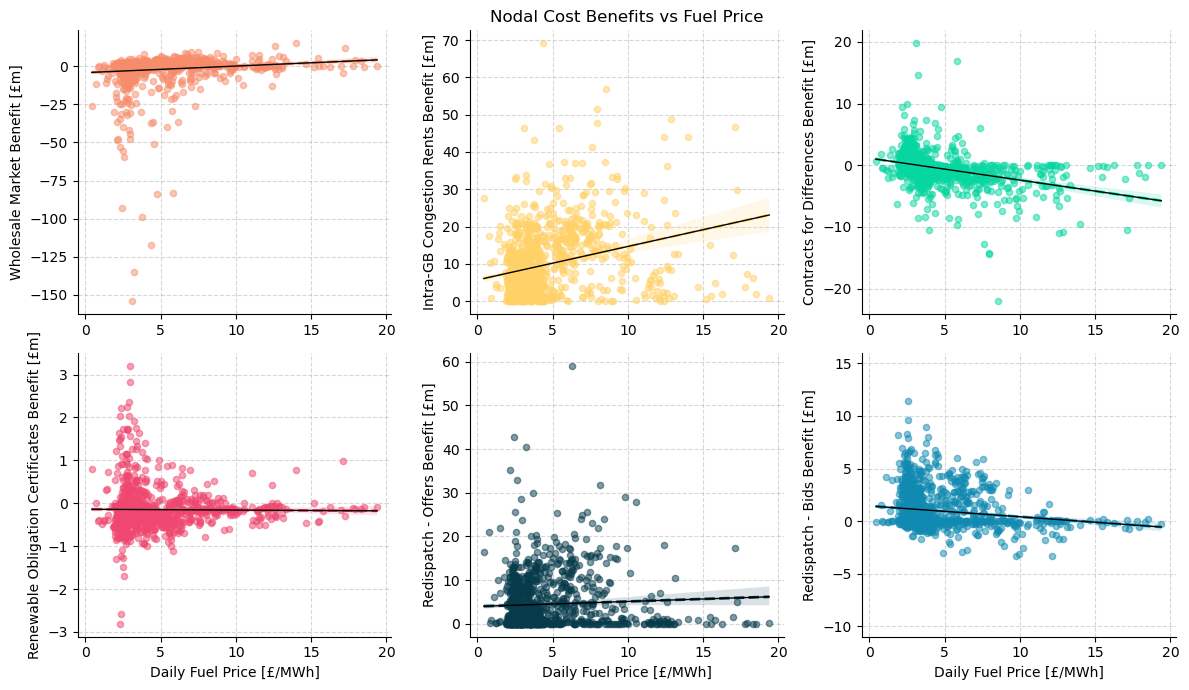

In [16]:
import seaborn as sns
from datetime import datetime


for layout in ['zonal', 'nodal']:

    fig, axs = plt.subplots(2, 3, figsize=(12, 7))

    ss = (results['national'] - results[layout]).unstack()

    ss = (
        ss
        .groupby([ss.index.year, ss.index.month, ss.index.day]).sum()
    )

    index = ss.index.to_frame()

    index['date'] = index.apply(lambda x: datetime(x[0], x[1], x[2]), axis=1)
    ss.index = index['date']
    ss.index = pd.to_datetime(ss.index).strftime('%Y-%m-%d')

    prices = total_fuel_price.loc[ss.index]


    for col, ax in zip(ss.columns, axs.flatten()):

        ax.scatter(
            prices,
            ss[col],
            color=color_dict[col],
            alpha=0.5,
            s=20,
            # edgecolor='k',
            )
    
        ax.grid(linestyle='--', alpha=0.5)
        ax.set_axisbelow(True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)


        sns.regplot(
            x=prices,
            y=ss[col],
            ax=ax,
            scatter=False,
            color=color_dict[col],
            line_kws={'linestyle':'--', 'linewidth': 2}
            )

        sns.regplot(
            x=prices,
            y=ss[col],
            ax=ax,
            scatter=False,
            color='k',
            ci=None,
            line_kws={'linestyle':'-', 'linewidth': 1}
            )

        ax.set_ylabel(f'{nice_names[col]} Benefit [£m]')
        

    axs[0,1].set_title(f'{layout.capitalize()} Cost Benefits vs Fuel Price')
    for ax in axs[1]:
        ax.set_xlabel('Daily Fuel Price [£/MWh]')

    for ax in axs[0]:
        ax.set_xlabel('')

    axs[1,2].set_ylim(-11, 16)
    if layout == 'zonal':
        axs[0,0].set_ylim(-160, 40)

    plt.tight_layout()

    plt.savefig('fuel_price_benefits_{}.pdf'.format(layout), bbox_inches='tight')
    plt.show()